# Deep Learning for Automated Essay Scoring

## Introduction

Automated essay scoring (AES) is an NLP task that aims to predict the score of an essay based on a certain set of essay quality metrics. The score depends on the grammatical, organizational, and content features of the essays. Human raters establish rubrics and provide scores based on these criteria. However, employing human raters can pose challenges due to the large number of essays to be graded (which slows down the feedback loop) and the inconsistent grades (different raters may assign different scores to the same essay, or a rater may assign different scores to the same essay if evaluated on different days).

AES systems are computer systems that simulate the scoring characteristics of human raters and address the aforementioned problems. There are several models used in AES systems. The most crucial aspect of an AES system is essay representation or encoding. Essay representation involves capturing useful features from the essays that help measure their quality. Manual feature engineering can extract features in the form of lexical, syntactic, or semantic features. This approach has been employed in industrial AES systems. However, such approaches have drawbacks in terms of generalizability and requiring feature engineering tasks.

Deep learning has become a go-to approach for numerous artificial intelligence tasks, consistently achieving outstanding performance results. Deep learning eliminates the need for feature engineering as it learns automatically behind the scenes.

In this project, I will demonstrate the use of deep learning for automated essay scoring tasks.

## Implementation

### Libraries
As it is seen in the following code snippet, I imported a number of libraries from <code>PyTorch</code>, <code>sklearn</code> and <code>python (collections)</code>. 
 - <code>torch</code> is a deep learning framework that I used it for building, training and testing my models.
 - <code>torchtext</code> is sub-library in PyTorch for text data that I used it to vectorize and tokenize the essays.
 - <code>Pandas</code> is a data manipulation tool which I used it for loading the data from the disk.
 - <code>matplotlib</code> is data visualization library which I used it for generating graphs.
 - <code>numpy</code> is large and multi-dimensional arrays library which I used it for tranforming data into array.
 - <code>scikit-learn</code> is a popular machine learning library which I used it for measuring rater agreement(<code>cohen_kappa_score</code>)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
#from torchtext.data import get_tokenizer
from transformers import AutoTokenizer, AutoModel

#from torchtext.vocab import vocab
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from collections import Counter, OrderedDict
import spacy
from collections import Counter

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta = AutoModel.from_pretrained("roberta-base")
roberta.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

### The Model
The following section shows the design of a multilayer perceptron model. The model has an embedding layer, 2 linear layers, 2 acitivation functions (ReLU and Sigmoid). 
 - The embedding layer: <code>nn.Embedding</code> is used to capture semantic and syntactic information from the essays.
 - The linear layers: <code>nn.Linear</code> represents linear transformation. In the model, there are two linear layers. The first linear layer takes an input from the embedding layer with embedding dimension (embedding_dim) size and generate an output with hidden dimension (hidden_dim) size. The second linear layer is used to generate the score (output).
 - Activation function: <code>nn.ReLU</code> and <code>nn.Sigmoid</code> are the activation function used to transform the linear layer into nonlinear. ReLU is applied to the first linear layer whereas sigmoid is applied tothe second linear layer.

This class has a constructor (<code>__init__</code>) and a forward pass (<code>forward</code>). In the constructor, the functions and the linear layers are setted. In the <code>forward</code> method, the order of computation is defined. The essay input (transformed into numbers) passed through the embedding layer. The intution here is it will capture semantic and syntactic information of the essay. And then, a mean pooling is applied. The first linear layer took the ouput of the averge pooled values and a ReLU actication function is applied over it. Finally, the second linear layer generates a value and adjusted using sigmoid activation function into a score.

In [2]:
class RobertaMLP(nn.Module):
    def __init__(self, hidden_size=768, mlp_hidden=256):
        super(RobertaMLP, self).__init__()
        self.roberta = AutoModel.from_pretrained("roberta-base")
        for name, param in self.roberta.named_parameters():
            if "layer.10" in name or "layer.11" in name:  # last 2 transformer layers
                param.requires_grad = True
            else:
                param.requires_grad = False


        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS]
        return self.mlp(cls_embedding)


### Custom Dataset class
I created a custom data <code>ASAPDataset</code> that takes a list of data and the vocab. This class contains three methods <code>__init__()</code>, <code>__len__()</code>, and <code>__getitem__()</code>. <code>__getitem__()</code> fetchs a sample from asap-aes dataset based on the given index. The <code>Dataset</code> provides a mechanism to load, preprocess, and iterate over the dataset.

In addition, there is <code>collate_fn</code> function defined to handle padding within the essay vectors. First, the maximum token length is identified and then set all the vectors of the essays to have the same length. The padding is represented using <code>0</code>.

In [3]:
class RobertaEssayDataset(torch.utils.data.Dataset):
    def __init__(self, texts, scores, tokenizer, max_len=256):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        score = self.scores[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "score": torch.tensor(score, dtype=torch.float32)
        }


### The Learning
In this section, I defined two functions, <code>training</code> and <code>testing</code>. The training function takes model, optimizer, dataset, and loss function. The model is an instance of the MLP class, optimizer is setted to Adam optimizer, the data is a batched data processd by the <code>DataLoader</code> and the criterion is a mean squared loss (MSE) function.

The training function is responsible for the learning component of the model. The model takes a batch of essays and produce an output with similar batch size. The output is in the range of 0-1 as it is squashed using <code>sigmoid</code> activation function. By transforming the actual score into the range of 0-1, loss of the model is computed. For transformation of the actual score into 0-1, I employed <code>Min-Max Normalization</code>.
$$
    min-max-normalization = \frac{score - min}{max  - min}
$$
where score is the essay score, min is the minimum score in the dataset and max is the maximum score in the dataset.

The other function in this section is, testing function. This function is used to evaluate the performance of the model. To evaluate the model, the output values are transformed into the actual score format. The model is evaluated against minimizing the loss and the agreement of AES system with the human raters. For minimizing the loss, <code>MSELoss</code> from <code>PyTorch</code> is employed.
$$
    MSE = \frac{1}{n}\sum(output - scores)^2
$$
where the output is score predicted by the model and scores are actual score from the dataset. The predicted score in both training and testing has a different form. In training phase, the predict score is in the range of 0-1 whereas during testing it is transformed into the range of in the dataset (please check for the actual scores range of the essay in the <code>essay_set</code> variable).

The other metrics used to measure the performance of the model is the raters' agreement. <code>scikit-learn</code> has an implementation of Cohen's kappa, <code>cohen_kappa_score</code>. This metrics measures the agreement level between raters. The score ranges from -1 to 1, where 1 indicates complete agreement, 0 agreement equivalent to chance and -1 complete disagreement.
$$
    k = 1 - \frac{\sum W_{i,j}O_{i,j}}{\sum W_{i,j}E_{i,j}}
$$
where $O_{i,j}$ is a histogram matrix with the number of predicted labels that have a rating  of $i$ (actual) that received a predicted value $j$, $E_{i,j}$ is a histogram matrix of expected ratings calculated as the outer product between the actual rating's histogram vector of ratings and the predicted rating's histogram vector of ratings.
$$
    W_{i, j} = \frac{(i-j)^2}{(R-1)^2}
$$
where $W_{i,j}$ is a weight matrix that is calculated based on the difference between actual and predicted values, and $R$ is the rating range.

In [4]:
def training(model, optimizer, data, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in data:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        scores = batch["score"].to(device).unsqueeze(1)

        output = model(input_ids, attention_mask)
        loss = criterion(output, scores)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data)


def testing(model, data, criterion, device, prompt):
    model.eval()
    total_loss = 0.0
    scores_4_qwk, output_4_qwk = [], []
    with torch.no_grad():
        for batch in data:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            scores = batch["score"].to(device).unsqueeze(1)

            output = model(input_ids, attention_mask)

            total_loss += criterion(output, scores).item()

            # convert back to original scale
            preds = [scaler(o.item(), prompt) for o in output]
            true_scores = [scaler(s.item(), prompt) for s in scores]

            scores_4_qwk.extend(true_scores)
            output_4_qwk.extend(preds)

    qwk = cohen_kappa_score(scores_4_qwk, np.round(output_4_qwk), weights="quadratic")
    return qwk, total_loss / len(data)


### Loading the dataset
The ASAP-AES dataset is a popular dataset among AES researchers. The dataset can be downloaded from [Kaggle](https://www.kaggle.com/c/asap-aes). The dataset has 12976 entries and 28 columns (features). But for this project, I am only interested on 4 features, namely essay_id, essay_set, essay, and domain1_score.
 - essay_id is a unique id column for each entry
 - essay_set is an essay category. There are 8 essay sets, and each set represent different questions and different scoring range.
 - essay is a text response to the prompt given by student. This column is importtant feautre in the scoring process.
 - domain1_score is a score column. This field the summation of scores from two raters. In this project, the target value is this field.

In [5]:
file_path = 'training_set_rel3.tsv'
columns = ['essay_id', 'essay_set', 'essay', 'domain1_score']
asap = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1', usecols=columns)
asap.head()
asap.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


The following section contains an essay_set dictionary and two functions. The essay_set dictionary contains the score range of each prompts. For example, essay_set 1 has minimum value of 2 and a maximum value 12. These values are taken from the dataset description. 

The min_max_normalization and scaler functions are used to transform the scores from score range of the dataset into the range of 0-1 and vice versa.

In [6]:
essay_set = {
    1: (2, 12),
    2: (1, 6),
    3: (0, 3),
    4: (0, 3),
    5: (0, 4),
    6: (0, 4),
    7: (0, 30),
    8: (0, 60)
}
def min_max_normalization(score, prompt):
    return (score - essay_set[prompt][0]) / (essay_set[prompt][1] - essay_set[prompt][0])
def scaler(score, prompt):
    return round(score * (essay_set[prompt][1] - essay_set[prompt][0]) + essay_set[prompt][0])

The dataset is splited into train, validation and test dataset. For training, 60% of the data is used, 20% of the data is used for validation and the rest is used for testing. <code>random_split</code> from PyTorch is used to spilt the data into the three settings.

In [7]:
def split_dataset(prompt): 
    train, val, test = torch.utils.data.random_split(asap[asap['essay_set']==prompt].values, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))
    return train, val, test

### Text representation
The following section shows where the texts are transformed into numbers. Every text in the essay is represented by a number.

In [8]:
def essay_dataloader(prompt, batch_size=16, max_len=256):
    df_prompt = asap[asap['essay_set'] == prompt]

    # Normalize scores
    df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
        lambda x: min_max_normalization(x, prompt)
    )

    train, val, test = np.split(
        df_prompt.sample(frac=1, random_state=42),
        [int(0.6*len(df_prompt)), int(0.8*len(df_prompt))]
    )

    train_ds = RobertaEssayDataset(train["essay"].tolist(), train["norm_score"].tolist(), tokenizer, max_len)
    val_ds   = RobertaEssayDataset(val["essay"].tolist(), val["norm_score"].tolist(), tokenizer, max_len)
    test_ds  = RobertaEssayDataset(test["essay"].tolist(), test["norm_score"].tolist(), tokenizer, max_len)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dl, val_dl, test_dl


In [9]:
def graphs(result, title, xlabel, ylabel, num_epochs, prompt):
    epochs = np.arange(1, num_epochs + 1, 1)
    #result = np.array(result)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if type(result[0]) == list:
        for idx, prompt_result in enumerate(result):
            plt.plot(epochs, np.array(prompt_result), label=f'Prompt {idx + 1}')
    else:
        plt.plot(epochs, np.array(result), label=f'Prompt {prompt}')
    plt.legend()
    plt.show()

In the ASAP-AES dataset, there are eight prompts. Therefore, we train, validate and test the model using each prompt.  

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
EPOCHS = 10
batch_size = 16

qwk_prompts_val, mse_prompts_val, qwk_prompts_test, mse_prompts_test  = [], [], [], []

for prompt in range(1, 9):
    train_dl, val_dl, test_dl = essay_dataloader(prompt, batch_size)
    
    model = RobertaMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    
    qwk_epoch, mse_epoch = [], []
    for epoch in range(EPOCHS):
        train_loss = training(model, optimizer, train_dl, criterion, device)
        qwk, mse = testing(model, val_dl, criterion, device, prompt)

        qwk_epoch.append(qwk)
        mse_epoch.append(mse)

        print(f"Prompt {prompt}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val QWK={qwk:.4f}, Val MSE={mse:.4f}")
        
    qwk_prompts_val.append(qwk_epoch)
    mse_prompts_val.append(mse_epoch)

    qwk_test, mse_test = testing(model, test_dl, criterion, device, prompt)
    qwk_prompts_test.append(qwk_test)
    mse_prompts_test.append(mse_test)


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 1, Epoch 1: Train Loss=0.1180, Val QWK=0.2588, Val MSE=0.0218
Prompt 1, Epoch 2: Train Loss=0.0225, Val QWK=0.4362, Val MSE=0.0185
Prompt 1, Epoch 3: Train Loss=0.0172, Val QWK=0.5160, Val MSE=0.0203
Prompt 1, Epoch 4: Train Loss=0.0164, Val QWK=0.6416, Val MSE=0.0135
Prompt 1, Epoch 5: Train Loss=0.0130, Val QWK=0.6509, Val MSE=0.0128
Prompt 1, Epoch 6: Train Loss=0.0127, Val QWK=0.6951, Val MSE=0.0128
Prompt 1, Epoch 7: Train Loss=0.0121, Val QWK=0.7038, Val MSE=0.0119
Prompt 1, Epoch 8: Train Loss=0.0120, Val QWK=0.7148, Val MSE=0.0117
Prompt 1, Epoch 9: Train Loss=0.0114, Val QWK=0.7244, Val MSE=0.0115
Prompt 1, Epoch 10: Train Loss=0.0105, Val QWK=0.7024, Val MSE=0.0115


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 2, Epoch 1: Train Loss=0.0455, Val QWK=0.3111, Val MSE=0.0192
Prompt 2, Epoch 2: Train Loss=0.0181, Val QWK=0.5216, Val MSE=0.0143
Prompt 2, Epoch 3: Train Loss=0.0154, Val QWK=0.5061, Val MSE=0.0143
Prompt 2, Epoch 4: Train Loss=0.0143, Val QWK=0.4921, Val MSE=0.0194
Prompt 2, Epoch 5: Train Loss=0.0141, Val QWK=0.5420, Val MSE=0.0136
Prompt 2, Epoch 6: Train Loss=0.0131, Val QWK=0.5156, Val MSE=0.0166
Prompt 2, Epoch 7: Train Loss=0.0118, Val QWK=0.5180, Val MSE=0.0141
Prompt 2, Epoch 8: Train Loss=0.0121, Val QWK=0.5966, Val MSE=0.0121
Prompt 2, Epoch 9: Train Loss=0.0115, Val QWK=0.6004, Val MSE=0.0120
Prompt 2, Epoch 10: Train Loss=0.0115, Val QWK=0.5756, Val MSE=0.0128


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 3, Epoch 1: Train Loss=0.1125, Val QWK=0.3017, Val MSE=0.0473
Prompt 3, Epoch 2: Train Loss=0.0557, Val QWK=0.6079, Val MSE=0.0363
Prompt 3, Epoch 3: Train Loss=0.0452, Val QWK=0.6775, Val MSE=0.0332
Prompt 3, Epoch 4: Train Loss=0.0412, Val QWK=0.6957, Val MSE=0.0319
Prompt 3, Epoch 5: Train Loss=0.0384, Val QWK=0.7015, Val MSE=0.0309
Prompt 3, Epoch 6: Train Loss=0.0382, Val QWK=0.7168, Val MSE=0.0308
Prompt 3, Epoch 7: Train Loss=0.0360, Val QWK=0.6566, Val MSE=0.0382
Prompt 3, Epoch 8: Train Loss=0.0343, Val QWK=0.7325, Val MSE=0.0298
Prompt 3, Epoch 9: Train Loss=0.0336, Val QWK=0.7327, Val MSE=0.0301
Prompt 3, Epoch 10: Train Loss=0.0329, Val QWK=0.7075, Val MSE=0.0302


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 4, Epoch 1: Train Loss=0.1273, Val QWK=0.5162, Val MSE=0.0494
Prompt 4, Epoch 2: Train Loss=0.0533, Val QWK=0.7221, Val MSE=0.0312
Prompt 4, Epoch 3: Train Loss=0.0405, Val QWK=0.7228, Val MSE=0.0302
Prompt 4, Epoch 4: Train Loss=0.0350, Val QWK=0.7918, Val MSE=0.0311
Prompt 4, Epoch 5: Train Loss=0.0321, Val QWK=0.7767, Val MSE=0.0302
Prompt 4, Epoch 6: Train Loss=0.0285, Val QWK=0.8189, Val MSE=0.0284
Prompt 4, Epoch 7: Train Loss=0.0281, Val QWK=0.7886, Val MSE=0.0292
Prompt 4, Epoch 8: Train Loss=0.0263, Val QWK=0.8222, Val MSE=0.0269
Prompt 4, Epoch 9: Train Loss=0.0252, Val QWK=0.8148, Val MSE=0.0270
Prompt 4, Epoch 10: Train Loss=0.0246, Val QWK=0.7876, Val MSE=0.0325


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 5, Epoch 1: Train Loss=0.0863, Val QWK=0.5140, Val MSE=0.0369
Prompt 5, Epoch 2: Train Loss=0.0327, Val QWK=0.7689, Val MSE=0.0188
Prompt 5, Epoch 3: Train Loss=0.0223, Val QWK=0.8025, Val MSE=0.0180
Prompt 5, Epoch 4: Train Loss=0.0199, Val QWK=0.7758, Val MSE=0.0218
Prompt 5, Epoch 5: Train Loss=0.0182, Val QWK=0.7904, Val MSE=0.0194
Prompt 5, Epoch 6: Train Loss=0.0173, Val QWK=0.7955, Val MSE=0.0184
Prompt 5, Epoch 7: Train Loss=0.0172, Val QWK=0.7801, Val MSE=0.0180
Prompt 5, Epoch 8: Train Loss=0.0159, Val QWK=0.7934, Val MSE=0.0188
Prompt 5, Epoch 9: Train Loss=0.0150, Val QWK=0.7963, Val MSE=0.0189
Prompt 5, Epoch 10: Train Loss=0.0143, Val QWK=0.7924, Val MSE=0.0175


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 6, Epoch 1: Train Loss=0.1195, Val QWK=0.2405, Val MSE=0.0419
Prompt 6, Epoch 2: Train Loss=0.0407, Val QWK=0.6531, Val MSE=0.0285
Prompt 6, Epoch 3: Train Loss=0.0248, Val QWK=0.7704, Val MSE=0.0175
Prompt 6, Epoch 4: Train Loss=0.0206, Val QWK=0.7780, Val MSE=0.0203
Prompt 6, Epoch 5: Train Loss=0.0195, Val QWK=0.7790, Val MSE=0.0189
Prompt 6, Epoch 6: Train Loss=0.0171, Val QWK=0.7884, Val MSE=0.0159
Prompt 6, Epoch 7: Train Loss=0.0163, Val QWK=0.7827, Val MSE=0.0180
Prompt 6, Epoch 8: Train Loss=0.0167, Val QWK=0.7840, Val MSE=0.0182
Prompt 6, Epoch 9: Train Loss=0.0162, Val QWK=0.8026, Val MSE=0.0157
Prompt 6, Epoch 10: Train Loss=0.0139, Val QWK=0.7875, Val MSE=0.0181


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 7, Epoch 1: Train Loss=0.0664, Val QWK=0.5383, Val MSE=0.0130
Prompt 7, Epoch 2: Train Loss=0.0158, Val QWK=0.7158, Val MSE=0.0098
Prompt 7, Epoch 3: Train Loss=0.0110, Val QWK=0.7764, Val MSE=0.0082
Prompt 7, Epoch 4: Train Loss=0.0099, Val QWK=0.7886, Val MSE=0.0076
Prompt 7, Epoch 5: Train Loss=0.0086, Val QWK=0.7852, Val MSE=0.0090
Prompt 7, Epoch 6: Train Loss=0.0087, Val QWK=0.8223, Val MSE=0.0069
Prompt 7, Epoch 7: Train Loss=0.0074, Val QWK=0.7868, Val MSE=0.0089
Prompt 7, Epoch 8: Train Loss=0.0071, Val QWK=0.8296, Val MSE=0.0067
Prompt 7, Epoch 9: Train Loss=0.0067, Val QWK=0.7980, Val MSE=0.0082
Prompt 7, Epoch 10: Train Loss=0.0067, Val QWK=0.8236, Val MSE=0.0073


C:\Users\ecc\AppData\Local\Temp\ipykernel_24296\118765499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prompt["norm_score"] = df_prompt["domain1_score"].apply(
C:\Users\ecc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Prompt 8, Epoch 1: Train Loss=0.1669, Val QWK=-0.0123, Val MSE=0.0165
Prompt 8, Epoch 2: Train Loss=0.0269, Val QWK=0.1272, Val MSE=0.0093
Prompt 8, Epoch 3: Train Loss=0.0106, Val QWK=0.2362, Val MSE=0.0086
Prompt 8, Epoch 4: Train Loss=0.0102, Val QWK=0.4275, Val MSE=0.0064
Prompt 8, Epoch 5: Train Loss=0.0078, Val QWK=0.4825, Val MSE=0.0067
Prompt 8, Epoch 6: Train Loss=0.0087, Val QWK=0.4326, Val MSE=0.0077
Prompt 8, Epoch 7: Train Loss=0.0062, Val QWK=0.5746, Val MSE=0.0053
Prompt 8, Epoch 8: Train Loss=0.0060, Val QWK=0.5951, Val MSE=0.0051
Prompt 8, Epoch 9: Train Loss=0.0052, Val QWK=0.6007, Val MSE=0.0049
Prompt 8, Epoch 10: Train Loss=0.0052, Val QWK=0.6090, Val MSE=0.0050


### Validation visualization
The following graphs are the visualization of validation dataset for raters agreement and the errors. The <code>y-axis</code> of <code>Model(Error)</code> shows an error of 0-35. The reason behind this large error value is the output scores are transformed into the original score range of the prompts during validation and testing.

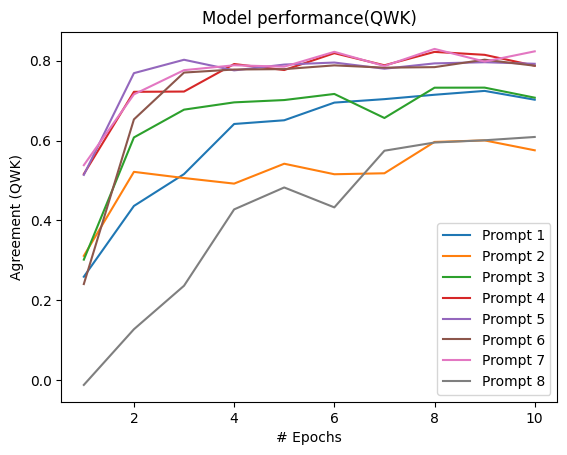

In [11]:
graph_settings = {
    'title': ('Model performance(QWK)', 'Model Error(MSE)'),
    'xlabel': '# Epochs',
    'ylabel': ('Agreement (QWK)', 'Error (MSE)')
}

graphs(qwk_prompts_val, graph_settings['title'][0], graph_settings['xlabel'], graph_settings['ylabel'][0], EPOCHS, prompt)

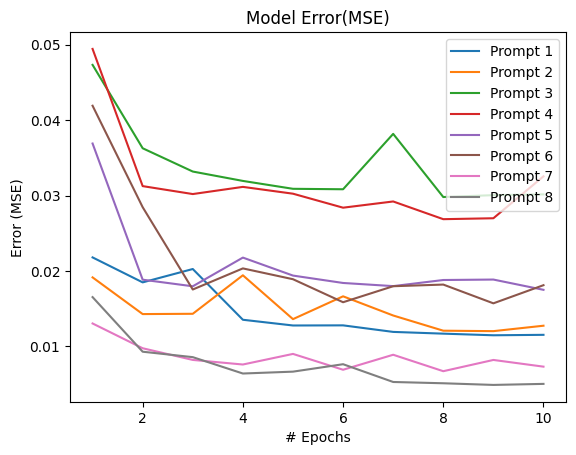

In [12]:
graphs(mse_prompts_val, graph_settings['title'][1], graph_settings['xlabel'], graph_settings['ylabel'][1], EPOCHS, prompt)

### Model Testing
The following graphs shows the perfomance of the model. The number of epochs  and hidden layers are fixed to 50 and 2 respectively.

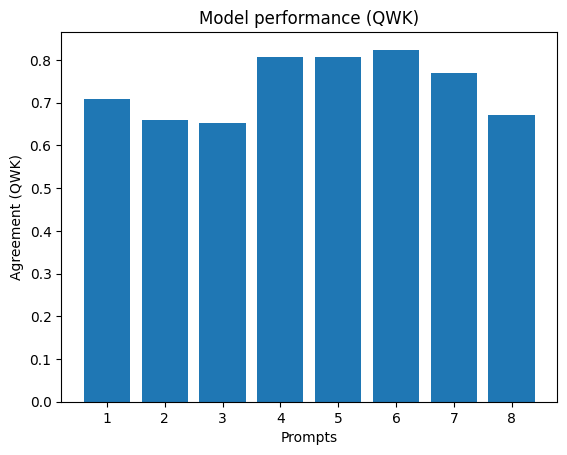

In [13]:
prompts = range(1, 9)
plt.bar(prompts, qwk_prompts_test)
plt.xlabel('Prompts')
plt.ylabel('Agreement (QWK)')
plt.title('Model performance (QWK)')
plt.show()